In [3]:
import numpy as np
from scipy import integrate
from scipy.stats import norm
from scipy.special import gammaincinv
import hmf, astropy, sys, tqdm, time
import pandas as pd
from astropy.cosmology import Planck18_arXiv_v2
import matplotlib.pyplot as plt

little_h = 0.68
baryon_frac = 0.188

mmin = 3. # Minimum halo mass for HMF
mmax = 15 # Maximum halo mass for HMF

maxMass = 12.5
dM = 0.5
dlog10m = 0.001 #numerical HMF resolution, should be <<mass resolution
Ndm = int(0.5//dlog10m) #number of steps in a 0.5 dex mass interval
Nm = 100 # set to 100
mbins = np.arange(3., maxMass+dM/Nm-1e-10, dM/Nm)
mbins=np.round(mbins, 3)

# Method to take one trial of a gamma distribution with a given variance and mean
def trial_minsig(sig_v, mean, Ntrials=10000, minsig = -7):
    Ntrials = int(Ntrials)
    var = sig_v**2*mean**2+mean #cv + poisson
    k = mean**2/var
    t = var/mean
    y = np.linspace(1/Ntrials,1-1/Ntrials, Ntrials)
    rand = t*gammaincinv(k, y, out = None)
    return rand

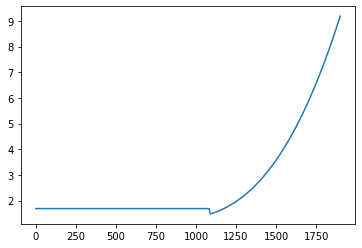

In [4]:
cvs = pd.read_csv('../calculate_sigma_cv/dfs/scaled_4.623_0.003.csv')

plt.plot(cvs.values[1][4:])


In [5]:
cvs

,Unnamed: 0,z,dz,sigdm,3.0,3.005,3.01,3.015,3.02,3.025,...,12.455,12.46,12.465,12.47,12.475,12.48,12.485,12.49,12.495,12.5
0,0,3.00185,0.0037,0.480105,1.721184,1.721184,1.721184,1.721184,1.721184,1.721184,...,9.215202,9.235401,9.255633,9.275899,9.296197,9.316529,9.336893,9.357291,9.377722,9.398187
1,1,3.43935,0.0043,0.427014,1.689825,1.689825,1.689825,1.689825,1.689825,1.689825,...,9.004573,9.024014,9.043487,9.062991,9.082527,9.102094,9.121692,9.141323,9.160985,9.180678
2,2,3.94970,0.0050,0.378324,1.652617,1.652617,1.652617,1.652617,1.652617,1.652617,...,8.764705,8.783340,8.802005,8.820700,8.839424,8.858179,8.876963,8.895777,8.914621,8.933495
3,3,4.55025,0.0059,0.333090,1.687455,1.687455,1.687455,1.687455,1.687455,1.687455,...,8.886133,8.904588,8.923071,8.941584,8.960126,8.978697,8.997297,9.015926,9.034584,9.053271
4,4,5.26435,0.0071,0.291072,1.796752,1.796752,1.796752,1.796752,1.796752,1.796752,...,9.372511,9.391360,9.410237,9.429144,9.448079,9.467043,9.486036,9.505059,9.524110,9.543190
5,5,6.12290,0.0086,0.252697,1.897390,1.897390,1.897390,1.897390,1.897390,1.897390,...,9.799052,9.818118,9.837213,9.856337,9.875489,9.894670,9.913879,9.933117,9.952384,9.971680
6,6,7.16825,0.0105,0.217712,2.050710,2.050710,2.050710,2.050710,2.050710,2.050710,...,10.419096,10.438531,10.457994,10.477485,10.497005,10.516554,10.536130,10.555735,10.575369,10.595030
7,7,8.45945,0.0131,0.185633,2.319003,2.319003,2.319003,2.319003,2.319003,2.319003,...,11.482572,11.502744,11.522945,11.543173,11.563429,11.583714,11.604026,11.624367,11.644736,11.665133
8,8,10.08010,0.0166,0.156561,2.585933,2.585933,2.585933,2.585933,2.585933,2.585933,...,12.437531,12.457912,12.478320,12.498755,12.519217,12.539705,12.560220,12.580762,12.601330,12.621926
9,9,12.15480,0.0214,0.130351,2.906031,2.906031,2.906031,2.906031,2.906031,2.906031,...,13.516006,13.536275,13.556568,13.576885,13.597227,13.617593,13.637983,13.658398,13.678838,13.699301


In [6]:
def evs_delta_sig(cv_df_loc = '../calculate_sigma_cv/dfs/scaled_4.623_0.003.csv', mf = hmf.MassFunction(), vol = 1, z = 4, Ntrials = int(1e4)):
    """

    Parameters
    ----------

    Returns
    -------
    phi:

    """
    cv_df = pd.read_csv(cv_df_loc)
    
    mf.update(z = z, Mmin = mmin, Mmax = mmax, dlog10m = dlog10m)
    dndm = mf.dndlog10m/little_h**4*vol
    mass = mf.m*little_h
    sbf = 0.02856609803835385 + 0.012162496006188494 * (z - 4) # could possibly include some uncertainty here
    stellar_mass = mass * sbf * baryon_frac 

    N_trapz = []
    for i in range(len(mass)-Ndm):
        inte = np.trapz(dndm[i:i+Ndm], np.log10(mass[i:i+Ndm]) ) #integrate over bin
        N_trapz.append(inte)
        
    N_trapz = np.array(N_trapz)   

    ## correction for bin size, applying later
    n_tot = integrate.trapz(dndm, np.log10(mass))
    f = n_tot/np.sum(N_trapz)
    print(np.sum(N_trapz)*f)
    stellar_mass = stellar_mass[int(Ndm)//2:-int(Ndm)//2] #redefine to fit integration range
    smfs = []
    cv_df_z  = cv_df.iloc[ np.argmin(np.abs(cv_df['z']-z)) ]
    cols = []
    for m in mbins[:-1]:
        cols.append(str(m) )
    cv_df_z[cols] = np.maximum.accumulate(cv_df_z[cols])

    for m in mbins[:-1]:
        arg = np.argmin(np.abs(np.log10(stellar_mass)-m))
        N = N_trapz[arg-1]
        cv = cv_df_z[str(m)]
        smfs.append(trial_minsig(float(cv), N, Ntrials = Ntrials, minsig = -10))
    
    smfs = np.vstack(smfs)*f
    Ns = np.sum(smfs, axis = 0)
    fs = smfs/Ns
    Fs = np.cumsum(smfs, axis = 0)/Ns
    phi_maxs = Ns*fs*pow(Fs, Ns-1)
    return phi_maxs, smfs, mbins, N_trapz

In [7]:
pm, smfs, mbins, N_trapz = evs_delta_sig(cv_df_loc = '../calculate_sigma_cv/dfs/scaled_4.623_0.003.csv')

8842196.556612428


<ipython-input-6-44722604c99a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_df_z[cols] = np.maximum.accumulate(cv_df_z[cols])
<ipython-input-6-44722604c99a>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_df_z[cols] = np.maximum.accumulate(cv_df_z[cols])


(1e-10, 1)

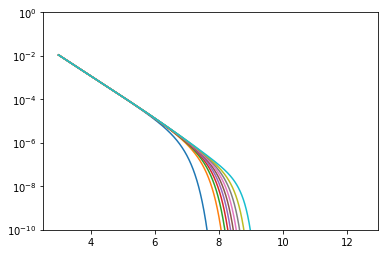

In [9]:
Ns = np.sum(smfs, axis = 0)
plt.plot(mbins[:-1], (smfs/Ns)[:, 1::1000])
plt.yscale('log')
plt.ylim(1e-10, 1)

In [288]:
smfs = smfs
Ns = np.sum(smfs, axis = 0)
fs = smfs/Ns
Fs = np.cumsum(smfs, axis = 0)/Ns
phi_maxs = Ns*fs*pow(Fs, Ns-1)

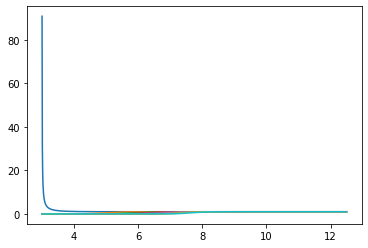

In [289]:
Ns = np.sum(smfs, axis = 0)
# plt.plot(mbins[:-1], Fs[:, 1::1000])
plt.plot(mbins[:-1], pow(Fs, Ns-1)[:, 1::1000] )

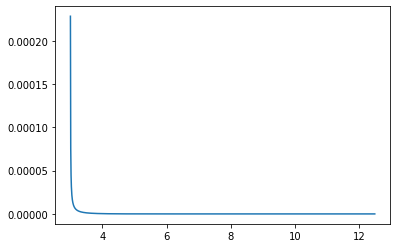

In [290]:
idx = 10
plt.plot(mbins[:-1], Ns[idx]*pow(Fs[:, idx], Ns[idx]-1)*fs[:, idx])

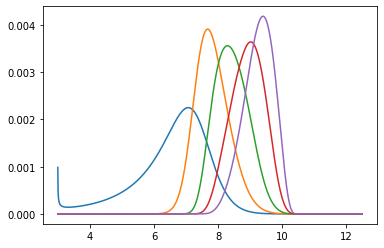

In [294]:
import scipy as sp
mask = ~np.any(np.isnan(phi_maxs), axis = 0)
phi_maxss = phi_maxs[:, mask]
N_trials = int(1e4)
N_OD = 10000
x = np.linspace(1e-8, 1-1e-8, N_trials )
for N_OD in [1, 10, 100, 1000, 10000]:
    evs_u = N_OD*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N_OD - 1.)
    evs_u = evs_u[mask]

    pdf_norm = np.sum(phi_maxss*evs_u, axis = 1)/np.sum(evs_u)

    plt.plot(mbins[:-1], pdf_norm )
# plt.xlim(7,10.5)

In [295]:
N_OD = 1
evs_u = N_OD*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N_OD - 1.)
evs_u = evs_u[mask]
pdf_norm = np.sum(phi_maxss*evs_u, axis = 1)/np.sum(evs_u)
cdf = np.cumsum(pdf_norm)/np.sum(pdf_norm)
mbins[np.argmin(np.abs(cdf-0.5))]

6.78

(10.0, 12.5)

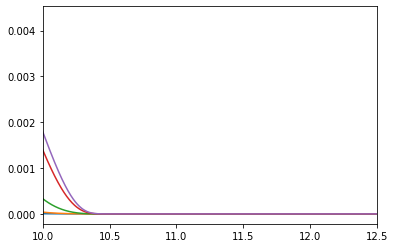

In [296]:
import scipy as sp
mask = ~np.any(np.isnan(phi_maxs), axis = 0)
phi_maxss = phi_maxs[:, mask]
N_trials = int(1e4)
N_OD = 10000
x = np.linspace(1e-8, 1-1e-8, N_trials )
for N_OD in [10, 100, 1000, 10000, 100000]:
    evs_u = N_OD*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N_OD - 1.)
    evs_u = evs_u[mask]

    pdf_norm = np.sum(phi_maxss*evs_u, axis = 1)/np.sum(phi_maxss*evs_u)

    plt.plot(mbins[:-1], pdf_norm )
plt.xlim(10,12.5)

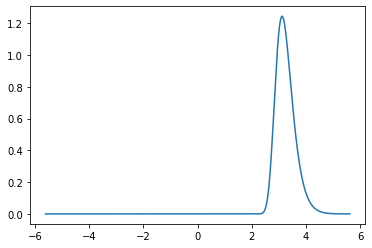

In [297]:
import scipy as sp
mask = ~np.any(np.isnan(phi_maxs), axis = 0)
phi_maxss = phi_maxs[:, mask]

N_OD = 1000
x = np.linspace(sp.stats.norm.ppf(1e-8), sp.stats.norm.ppf(1-1e-8), int(N_trials) )
evs_g = N_OD*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N_OD - 1.)
evs_g = evs_g[mask]

plt.plot(x[mask], evs_g)


(0.9, 1.0)

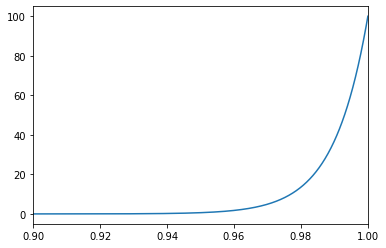

In [298]:
N_OD = 100
x = np.linspace(1e-8, 1-1e-8, int(N_trials) )
evs_u = N_OD*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N_OD - 1.)
evs_u = evs_u[mask]
plt.plot(x[mask], evs_u)
plt.xlim(0.9, 1.0)

In [301]:
def evs_hypersurface_pdf(mf = hmf.MassFunction(), V = 33510.321, z = 4):
    """
    Calculate extreme value probability density function for the dark matter
    halo population on a spatial hypersurface (fixed redshift).

    Parameters
    ----------
    mf : mass function, from `hmf` package
    V : volume (default: a sphere with radius 20 Mpc)

    Returns
    -------
    phi:

    """
    mf.update(z = z, Mmin = mmin, Mmax = mmax, dlog10m = dlog10m)
    dndm = mf.dndlog10m/little_h**4*V
    mass = mf.m*little_h
    sbf = 0.02856609803835385 + 0.012162496006188494 * (z - 4) # could possibly include some uncertainty here
    stellar_mass = mass * sbf * baryon_frac 
    n_tot = integrate.trapz(dndm, np.log10(mass))
    f = dndm[:-1] / n_tot
    F = integrate.cumtrapz(dndm, np.log10(mass)) / n_tot
    N = n_tot
    print(N)
    phi_max = N*f*(F**(N-1))
    return phi_max, stellar_mass[:-1]

phi_evs, M_evs = evs_hypersurface_pdf(V = 1)

8842196.556612428


In [276]:
# N_trapz
# 1890583.292428356/8842196.556612428


0.21381375999999996

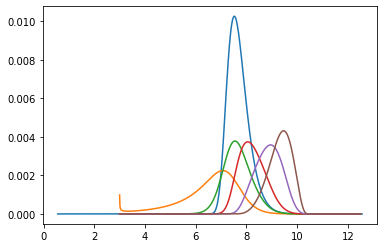

In [305]:
plt.plot(np.log10(M_evs), phi_evs/100)
import scipy as sp
mask = ~np.any(np.isnan(phi_maxs), axis = 0)
phi_maxss = phi_maxs[:, mask]
N_trials = int(1e4)
N_OD = 10000
x = np.linspace(1e-8, 1-1e-8, N_trials )
for N_OD in [1, 6, 44, 760, 31000]:
    evs_u = N_OD*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N_OD - 1.)
    evs_u = evs_u[mask]

    pdf_norm = np.sum(phi_maxss*evs_u, axis = 1)/np.sum(evs_u)

    plt.plot(mbins[:-1], pdf_norm )
# plt.xlim(10,12.5)

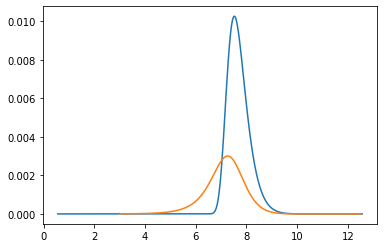

In [307]:
plt.plot(np.log10(M_evs), phi_evs/100)
import scipy as sp
mask = ~np.any(np.isnan(phi_maxs), axis = 0)
phi_maxss = phi_maxs[:, mask]
N_trials = int(1e4)
N_OD = 10000
x = np.linspace(1e-8, 1-1e-8, N_trials )
for N_OD in [2]:
    evs_u = N_OD*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N_OD - 1.)
    evs_u = evs_u[mask]

    pdf_norm = np.sum(phi_maxss*evs_u, axis = 1)/np.sum(evs_u)

    plt.plot(mbins[:-1], pdf_norm )
# plt.xlim(10,12.5)